In [1]:
import psycopg2
from IPython.display import Image
import copy
import json
import pydot

from tree_node import TreeNode
from qep_stats import * 
from parse_tree import parseJsonNode, getTreeBFS

In [2]:
def connect(query):
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
        host='localhost' #'172.21.148.168'
        database='classicmodels'
        user='signapoop' #'db'
        password='none' #'dbproj'
 
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(host=host,database=database, user=user, password=password)

        cur = conn.cursor()
        cur.execute(query)
        result = cur.fetchall()
        
        # close the communication with the PostgreSQL
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
            print('Database connection closed.')
    return result

In [3]:
query = \
"EXPLAIN(ANALYZE, FORMAT JSON) \
SELECT c.customerNumber, COUNT(*) \
FROM customers c, orders o, orderdetails od \
WHERE c.customerNumber = o.customerNumber AND o.orderNumber = od.orderNumber AND od.quantityOrdered > 1 \
GROUP BY c.customerNumber \
HAVING COUNT(*) > 4;"

In [4]:
# query = \
# "EXPLAIN(FORMAT JSON) \
# SELECT c.customerNumber, COUNT(*) \
# FROM customers c, orders o, orderdetails od \
# WHERE c.customerNumber > o.customerNumber AND o.orderNumber = od.orderNumber AND od.quantityOrdered > 1 \
# GROUP BY c.customerNumber \
# HAVING COUNT(*) > 4;"

In [5]:
# query = \
# "EXPLAIN (ANALYZE, FORMAT JSON)\
# SELECT o.officecode, o.city, COUNT(*) \
# FROM employees c, offices o \
# WHERE c.officecode = o.officecode \
# GROUP BY o.officecode \
# HAVING COUNT(*) > 1;"

In [6]:
result = connect(query)

Connecting to the PostgreSQL database...
Database connection closed.


In [7]:
print(json.dumps(result[0][0], sort_keys=True, indent=4))

[
    {
        "Execution Time": 5.331,
        "Plan": {
            "Actual Loops": 1,
            "Actual Rows": 97,
            "Actual Startup Time": 5.011,
            "Actual Total Time": 5.04,
            "Filter": "(count(*) > 4)",
            "Group Key": [
                "c.customernumber"
            ],
            "Node Type": "Aggregate",
            "Parallel Aware": false,
            "Partial Mode": "Simple",
            "Plan Rows": 41,
            "Plan Width": 16,
            "Plans": [
                {
                    "Actual Loops": 1,
                    "Actual Rows": 2996,
                    "Actual Startup Time": 0.627,
                    "Actual Total Time": 3.868,
                    "Hash Cond": "(o.customernumber = c.customernumber)",
                    "Inner Unique": true,
                    "Join Type": "Inner",
                    "Node Type": "Hash Join",
                    "Parallel Aware": false,
                    "Parent Relationship"

In [8]:
def plotBFS(root, graph):
    frontier = [root]
    i = 0
    while frontier:
        next_level = []
        for u in frontier:
            #print("level {}, val {}, title {}".format(i, n.val, n.title))
            for v in u.children: 
                edge = pydot.Edge(u.pydot_node, v.pydot_node)
                graph.add_edge(edge)
                next_level.append(v)
        frontier = next_level
        i += 1

def plotQueryTree(qep, filename='test.png'):
    assert 'Plan' in qep[0], "Invalid JSON was given"
    root = parseJsonNode(qep[0]['Plan'])
    all_nodes = getTreeBFS(root)
    
    # Compute statistics
    execution_time = qep[0].get('Execution Time', None)
    planning_time = qep[0].get('Planning Time', None)
    calculateActualCost(all_nodes)
    calculateActualDuration(all_nodes)
    largest_row = markLargestNode(all_nodes)
    largest_cost = markCostliestNode(all_nodes)
    largest_duration = markSlowestNode(all_nodes)
    calculatePercentDuration(all_nodes, execution_time)
    
    stats = {'execution_time': execution_time, 
             'planning_time': planning_time,
             'largest_row': largest_row, 
             'largest_cost': largest_cost, 
             'largest_duration': largest_duration}
    
    graph = pydot.Dot(graph_type='graph')
    for node in all_nodes:
        node.pydot_node = pydot.Node(node.to_string(), shape='box')
        graph.add_node(node.pydot_node)
    plotBFS(all_nodes[0], graph)
    graph.write_png(filename)
    return filename, all_nodes, stats

In [9]:
qep = result[0][0]
filename, all_nodes, stats = plotQueryTree(qep)

In [10]:
print(stats)

{'execution_time': 5.331, 'planning_time': 1.812, 'largest_row': 2996, 'largest_cost': 65.45, 'largest_duration': 1.18}


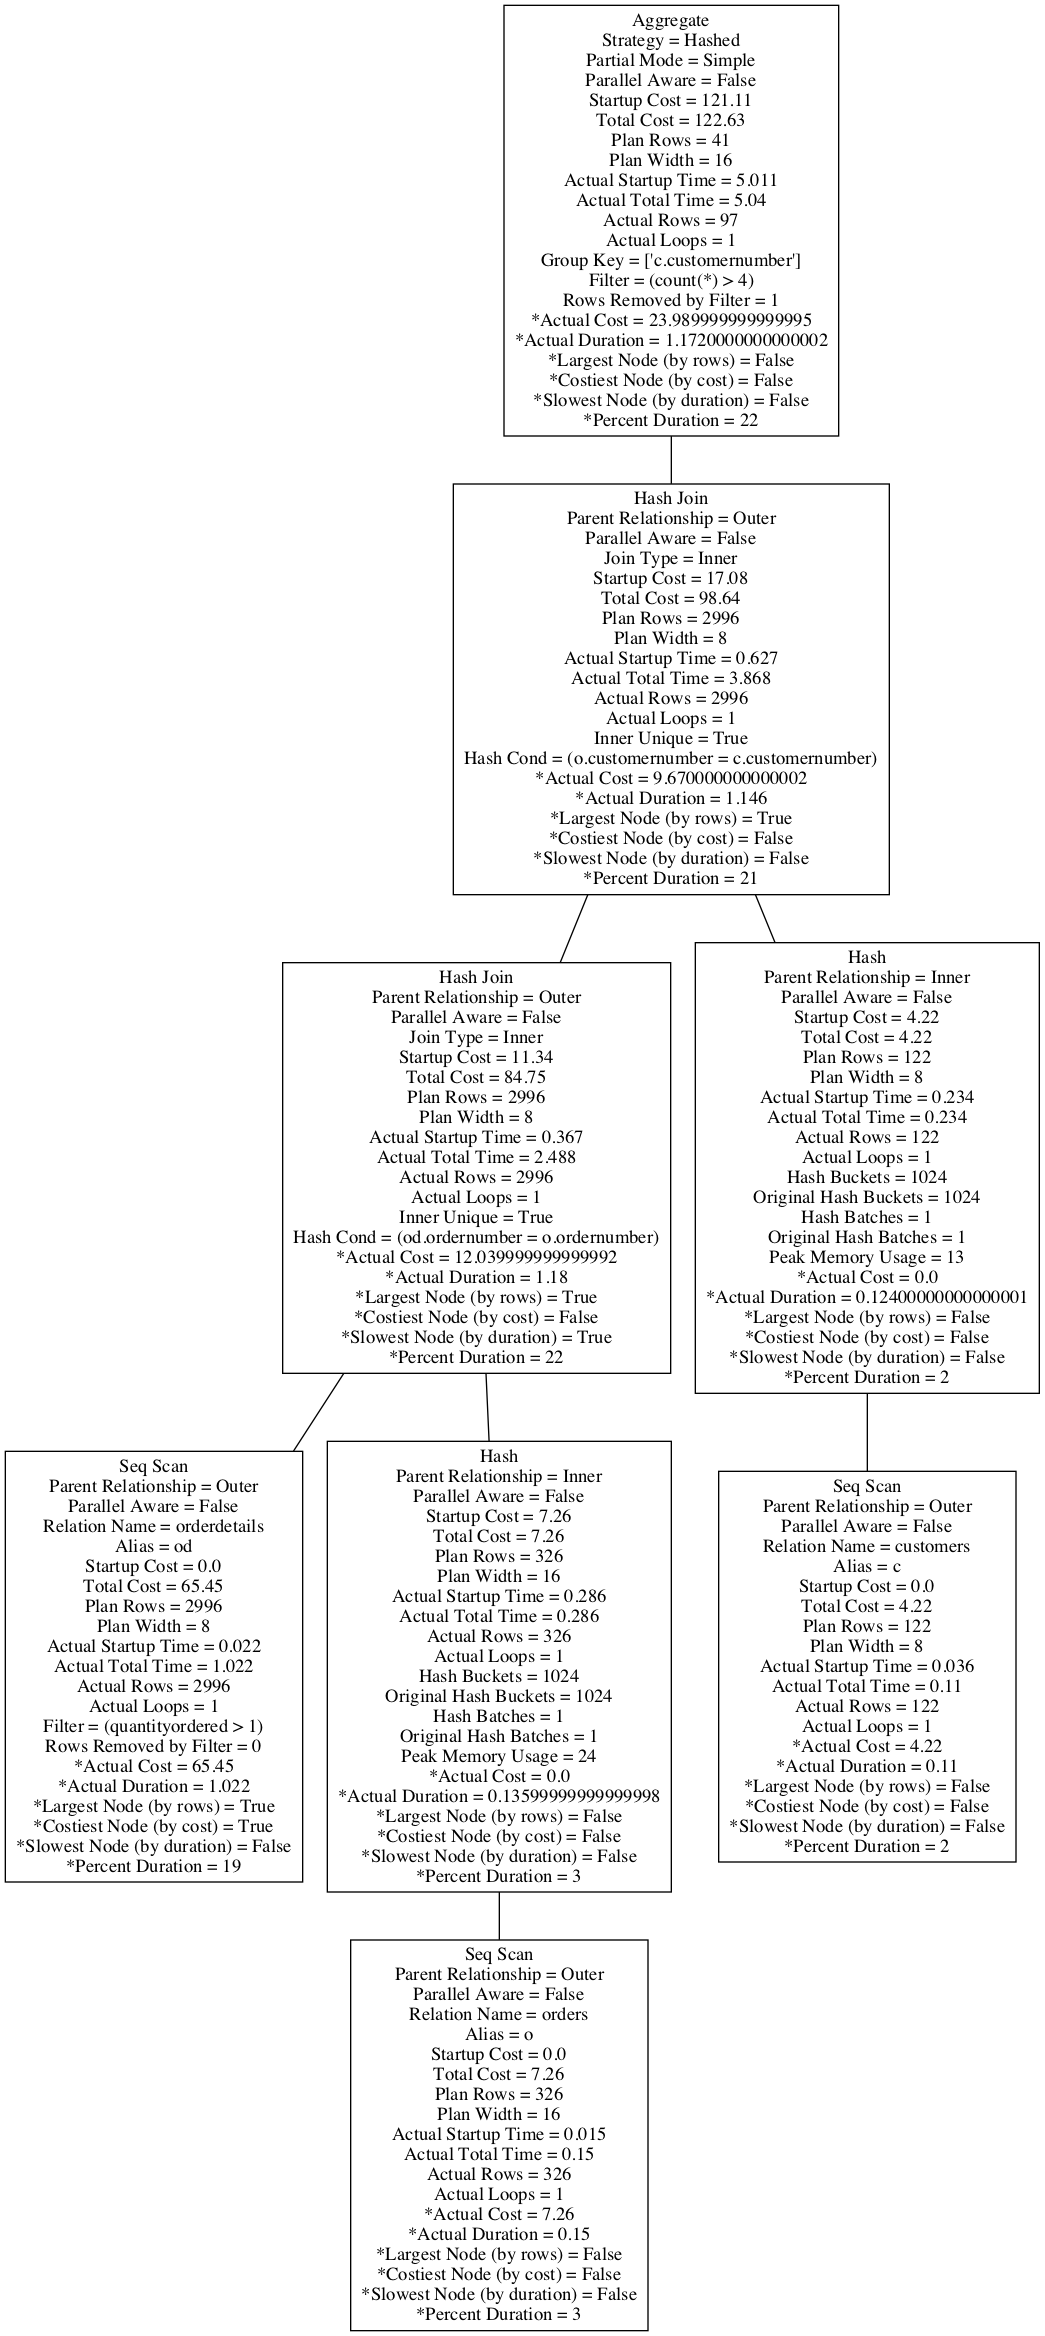

In [11]:
Image(filename)

In [12]:
with open('stats.json', 'w') as outfile:
    json.dump(stats, outfile)

In [13]:
with open('qep.json', 'w') as outfile:
    json.dump(all_nodes[0].to_json(), outfile, indent=4)